# Support Vector Machines
Ing. Luis Felipe Narvaez Gomez. E-mail: luis.narvaez@usantoto.edu.co. Cod: 2312660. Facultad de Ingeniria de Sistemas. USTA

References: https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html


## Ejemplo: Reconocimiento Facial

Como ejemplo de máquinas de vectores de soporte en acción, echemos un vistazo al problema del reconocimiento facial. Usaremos el conjunto de datos Labeled Faces in the Wild, que consta de varios miles de fotos recopiladas de varias figuras públicas. Un buscador para el conjunto de datos está integrado en Scikit-Learn:

In [11]:
# Algunas librerias iniciales serian:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()
from IPython.display import Image

from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.svm import SVC
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d

In [3]:
from sklearn.datasets import fetch_lfw_people

In [4]:
faces = fetch_lfw_people(min_faces_per_person=60)

In [5]:
print(faces.target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']


In [6]:
print(faces.images.shape)

(1348, 62, 47)


Grafiquemos algunas de estas caras para ver con qué estamos trabajando:

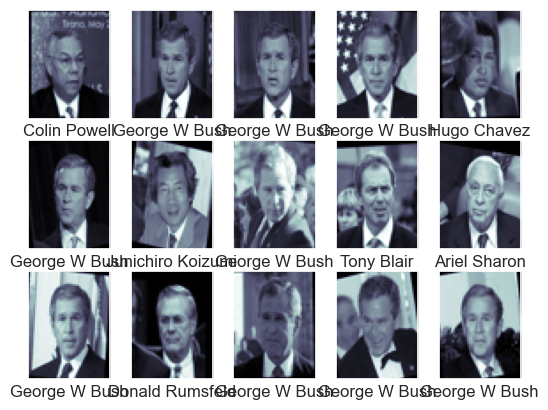

In [9]:
fig, ax = plt.subplots(3, 5)

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Cada imagen contiene [62×47] o casi 3000 píxeles. Podríamos proceder simplemente usando cada valor de píxel como una característica, pero a menudo es más efectivo usar algún tipo de preprocesador para extraer características más significativas; aquí usaremos un análisis de componentes principales para extraer 150 componentes fundamentales para alimentar nuestro clasificador de máquinas de vectores de soporte.

Podemos hacer esto de la manera más sencilla empaquetando el preprocesador y el clasificador en una sola canalización:

In [14]:
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA as RandomizedPCA

In [15]:
from sklearn.pipeline import make_pipeline

In [16]:
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

En aras de probar la salida de nuestro clasificador, dividiremos los datos en un conjunto de entrenamiento y prueba:

In [19]:
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

In [20]:
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,random_state=42)

Finalmente, podemos usar una validación cruzada de búsqueda en cuadrícula para explorar combinaciones de parámetros.

Aquí ajustaremos $C$(que controla la dureza del margen) y $gamma$ (que controla el tamaño del núcleo de la función de base radial), y determinaremos el mejor modelo:

In [22]:
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

"""
Los siguientes modulos fueron actualizados 
para ser de la siguiente forma:

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
"""

'\nLos siguientes modulos fueron actualizados \npara ser de la siguiente forma:\n\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.model_selection import train_test_split\n'

In [23]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 1min 31s
Wall time: 23.8 s
{'svc__C': 50, 'svc__gamma': 0.005}


Los valores óptimos caen hacia la mitad de nuestra cuadrícula; si cayeran en los bordes, querríamos expandir la cuadrícula para asegurarnos de haber encontrado el verdadero óptimo.

Ahora, con este modelo de validación cruzada, podemos predecir las etiquetas de los datos de prueba, que el modelo aún no ha visto:

In [24]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Echemos un vistazo a algunas de las imágenes de prueba junto con sus valores predichos:

Text(0.5, 0.98, 'Nombres previstos; etiquetas incorrectas en rojo')

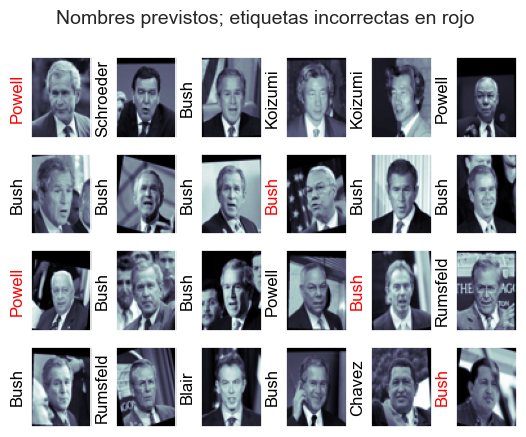

In [25]:
fig, ax = plt.subplots(4, 6)

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1], color='black' if yfit[i] == ytest[i] else 'red')

fig.suptitle('Nombres previstos; etiquetas incorrectas en rojo', size=14)

De esta pequeña muestra, nuestro estimador óptimo etiquetó incorrectamente $5$ caras ($POWEL y BUSH$ con caras de otras personas.

 Podemos tener una mejor idea del rendimiento de nuestro estimador utilizando el informe de clasificación, que enumera las estadísticas de recuperación etiqueta por etiqueta:

In [26]:
from sklearn.metrics import classification_report

In [27]:
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.91      0.67      0.77        15
     Colin Powell       0.85      0.85      0.85        68
  Donald Rumsfeld       0.72      0.58      0.64        31
    George W Bush       0.76      0.92      0.83       126
Gerhard Schroeder       0.75      0.65      0.70        23
      Hugo Chavez       1.00      0.45      0.62        20
Junichiro Koizumi       0.91      0.83      0.87        12
       Tony Blair       0.80      0.76      0.78        42

         accuracy                           0.80       337
        macro avg       0.84      0.71      0.76       337
     weighted avg       0.80      0.80      0.79       337



También podríamos mostrar la matriz de confusión entre estas clases:

In [28]:
from sklearn.metrics import confusion_matrix

Text(110.44999999999996, 0.5, 'predicted label')

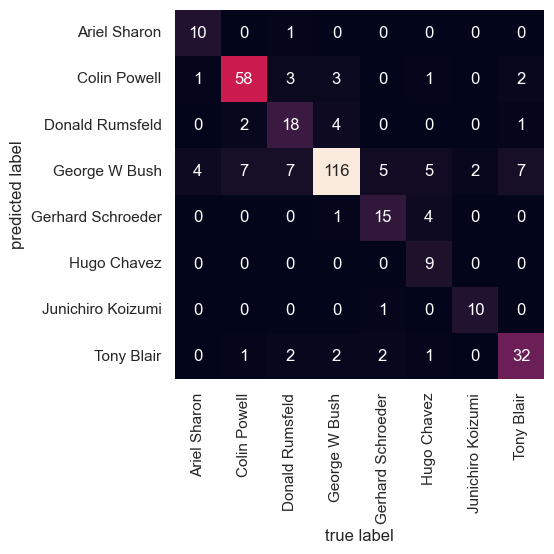

In [29]:
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

Esto nos ayuda a tener una idea de qué etiquetas es probable que el estimador confunda.

Para una tarea de reconocimiento facial del mundo real, en la que las fotos no vienen recortadas en bonitas cuadrículas, la única diferencia en el esquema de clasificación facial es la selección de características: necesitaría usar un algoritmo más sofisticado para encontrar las caras, y extraer características que son independientes de la pixelación. 

Para este tipo de aplicación, una buena opción es hacer uso de OpenCV , que, entre otras cosas, incluye implementaciones preentrenadas de herramientas de extracción de características de última generación para imágenes en general y rostros en particular.